# CONVOLUTIONAL NEURAL NETWORKS

This notebook implements some helper functions to compute convolutions in image domain.
It is implemented for learning purposes.

Reference: 
https://d2l.ai/chapter_convolutional-neural-networks/padding-and-strides.html

In [2]:
# IMPORT LIBRARIES
import torch
from torch import nn

### Cross Correlation
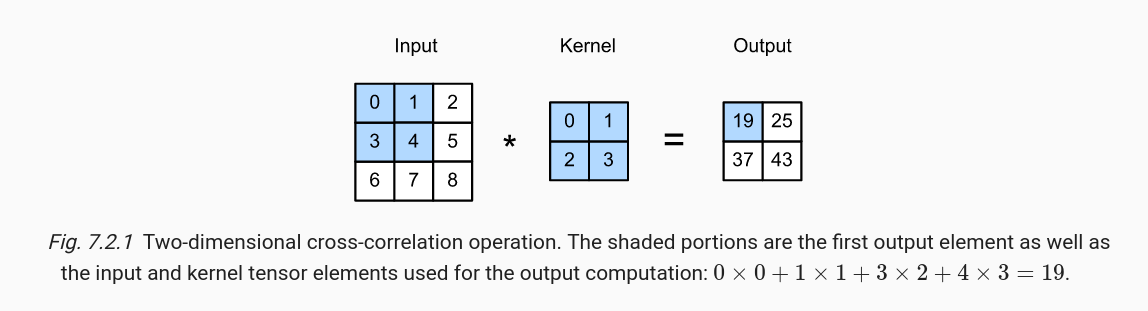

In [3]:
def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y


In [4]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)


tensor([[19., 25.],
        [37., 43.]])

### Convolutional Layers

A convolutional layer cross-correlates the input and kernel and adds a scalar bias to produce an output. The two parameters of a convolutional layer are the kernel and the scalar bias. When training models based on convolutional layers, we typically initialize the kernels randomly, just as we would with a fully connected layer.

We are now ready to implement a two-dimensional convolutional layer based on the corr2d function defined above. In the __init__ constructor method, we declare weight and bias as the two model parameters. The forward propagation function calls the corr2d function and adds the bias.

In [5]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias


In [6]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [9]:
K = torch.tensor([[1.0, -1.0]])
K

tensor([[ 1., -1.]])

In [10]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

We can now apply the kernel to the transposed image. As expected, it vanishes. The kernel K only detects vertical edges.

In [11]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### Learning a Kernel

Designing an edge detector by finite differences [1, -1] is neat if we know this is precisely what we are looking for. However, as we look at larger kernels, and consider successive layers of convolutions, it might be impossible to specify precisely what each filter should be doing manually.

Now let’s see whether we can learn the kernel that generated Y from X by looking at the input–output pairs only. We first construct a convolutional layer and initialize its kernel as a random tensor. Next, in each iteration, we will use the squared error to compare Y with the output of the convolutional layer. We can then calculate the gradient to update the kernel. For the sake of simplicity, in the following we use the built-in class for two-dimensional convolutional layers and ignore the bias.

In [18]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate
print(f'X: {X}')
print(f'Y: {Y}')

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')


X: tensor([[[[1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.]]]])
Y: tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]])
epoch 2, loss 2.229
epoch 4, loss 0.623
epoch 6, loss 0.206
epoch 8, loss 0.076
epoch 10, loss 0.030


In [14]:
conv2d.weight.data.reshape((1, 2))


tensor([[ 0.9281, -1.0508]])

### Padding
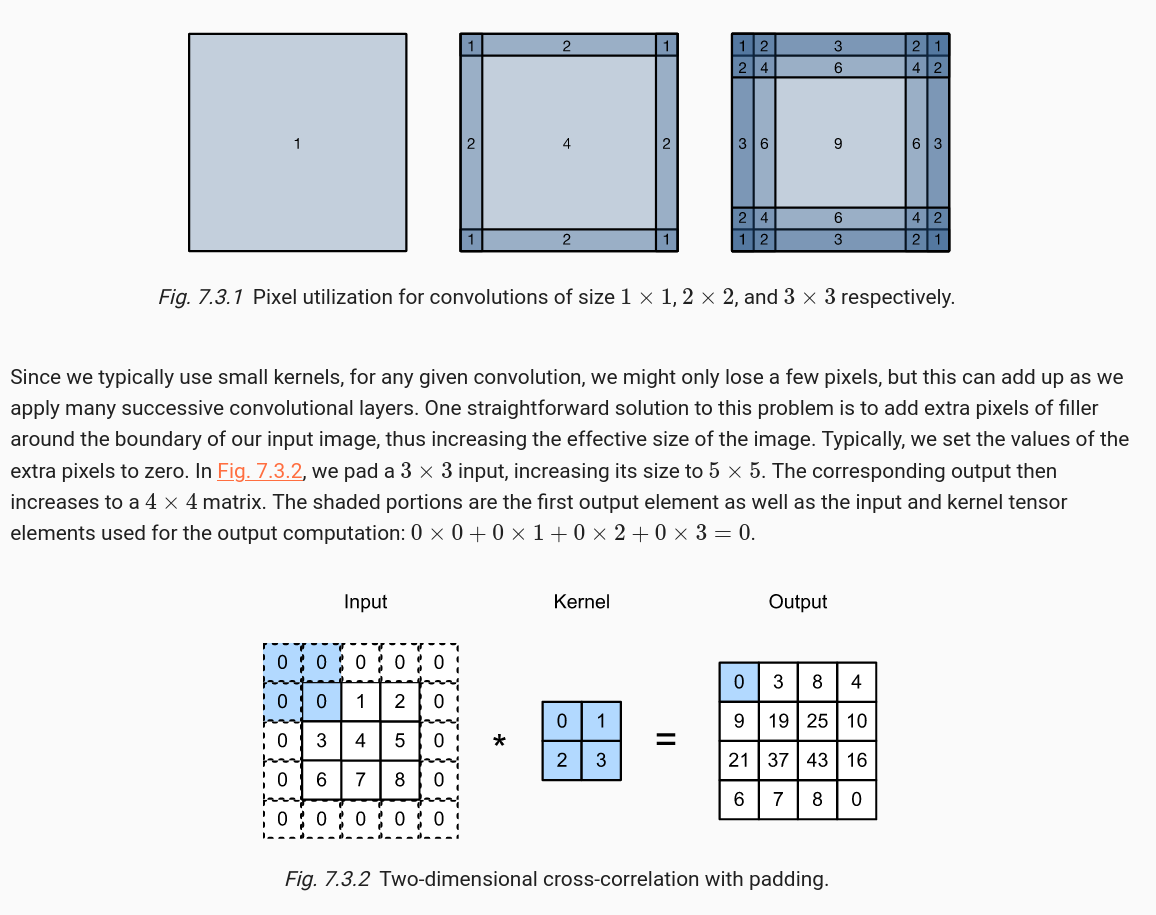
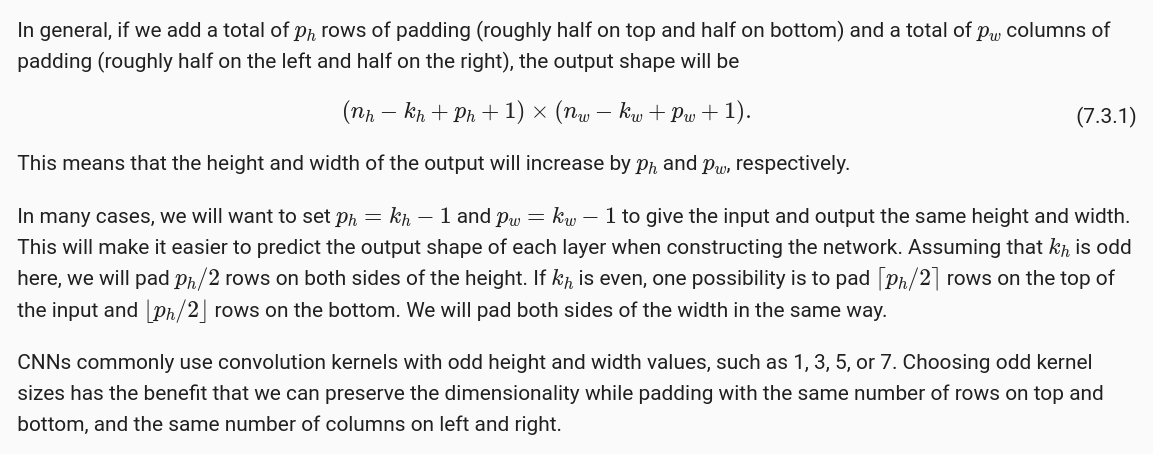

In [20]:
# We define a helper function to calculate convolutions. It initializes
# the convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output.
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])
# 1 row and column is padded on either side, so a total of 2 rows or columns are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [22]:
conv2d = nn.LazyConv2d(1, kernel_size=5, padding=2)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])